In [1]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
sys.path.append('../..')

In [2]:
from lamarck import Optimizer, BlueprintBuilder, DataExplorer, HistoryExplorer

# Setup

#### Process

In [3]:
def process(x, y):
    val = np.sin(x)*x + np.sin(y)*y
    return {'val': val}

In [4]:
maxrange = 12

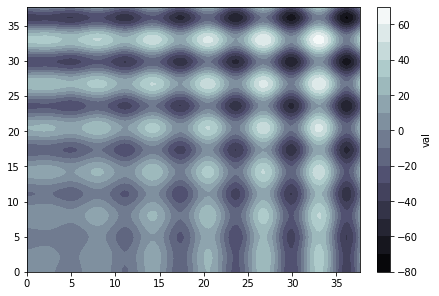

In [5]:
x = np.linspace(0, maxrange*np.pi, 100)
y = np.linspace(0, maxrange*np.pi, 100)
Xi, Yi = np.meshgrid(x, y)
Z = process(Xi, Yi)['val']

fig, ax = plt.subplots(constrained_layout=True)
CS = ax.contourf(x, y, Z, 15, cmap=plt.cm.bone)
cbar = fig.colorbar(CS)
_ = cbar.ax.set_ylabel('val')

# Finding best solutions

#### Genome Creation

In [6]:
builder = BlueprintBuilder()
builder.add_float_gene(name='x',
                       domain=(0, maxrange*np.pi))
builder.add_float_gene(name='y',
                       domain=(0, maxrange*np.pi))

builder._blueprint

{'x': {'type': 'float', 'specs': {'domain': (0, 37.69911184307752)}},
 'y': {'type': 'float', 'specs': {'domain': (0, 37.69911184307752)}}}

In [7]:
blueprint = builder.get_blueprint()

#### Population

In [8]:
pop = blueprint.populate.deterministic(20) + blueprint.populate.random(600)

In [9]:
opt = Optimizer(pop, process)

### Create Optimizer

In [10]:
opt = Optimizer(population=pop, process=process) 

### Explore variable space

In [11]:
plotter = DataExplorer(opt)

<AxesSubplot:xlabel='x', ylabel='y'>

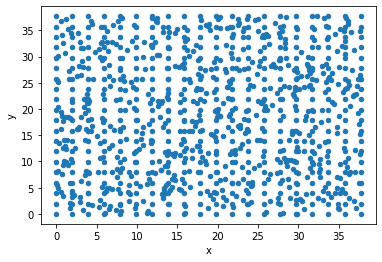

In [12]:
plotter.variable_pair('x', 'y')

### Simulate

In [13]:
opt.simulate.single_criteria(output='val', objective='max', quiet=True)

Generation 13 of 20 (stall: 5 of 5):  65%|█████████████████████████████████████████████████████▉                             | 13/20 [00:54<00:29,  4.18s/it]


In [14]:
opt.datasets.get_best_criature()

x           33.030751
y           32.976327
val         65.973287
Criteria    65.973287
Rank         1.000000
Name: d483bf8dc10e483c595efe8b8603fa8cc24a02d39ef700d57bcb94928adc37ed, dtype: float64

# Evolution of the Species 

In [15]:
gen = 0

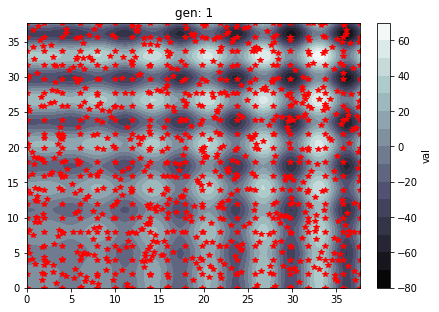

In [16]:
gen += 1
f = opt.datasets.history.generation == gen
df = opt.datasets.history[f]

ax.lines = []
ax.plot(df.x, df.y, 'r*')
ax.set_title(label=f'gen: {gen}')
ax.figure.savefig(f'evol_{gen}', bbox_inches='tight')
ax.figure

In [17]:
plotter = HistoryExplorer(opt)

<AxesSubplot:xlabel='generation', ylabel='val'>

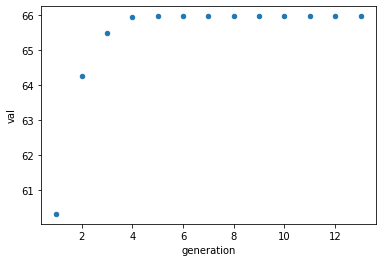

In [18]:
plotter.history('val', np.max)

# Starting away from optimum

In [19]:
constraint = lambda x, y: (x < 10) & (y < 10)
blueprint.add_constraint(constraint)

In [20]:
new_pop = blueprint.populate.deterministic(20) + blueprint.populate.random(600)

In [37]:
opt = Optimizer(new_pop, process)

## WITHOUT Mutation

In [22]:
opt.config.p_mutation = 0

In [23]:
opt.simulate.single_criteria(output='val', objective='max', quiet=True)

Generation 9 of 20 (stall: 5 of 5):  45%|██████████████████████████████████████▎                                              | 9/20 [00:03<00:04,  2.57it/s]


In [26]:
gen = 1

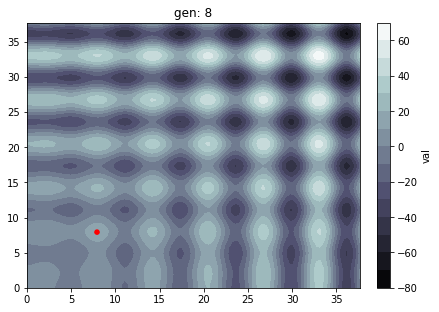

In [34]:
f = opt.datasets.history.generation == gen
df = opt.datasets.history[f]


ax.lines = []
ax.plot(df.x, df.y, 'r.')
ax.set_title(label=f'gen: {gen}')
gen += 1
ax.figure

### Creatures get stuck

## WITH Mutation

In [38]:
opt = Optimizer(new_pop, process)

In [39]:
opt.config.p_mutation = 0.1

In [40]:
opt.simulate.single_criteria(output='val', objective='max', quiet=True)

Generation 15 of 20 (stall: 5 of 5):  75%|██████████████████████████████████████████████████████████████▎                    | 15/20 [00:05<00:01,  2.60it/s]


In [42]:
gen = 1

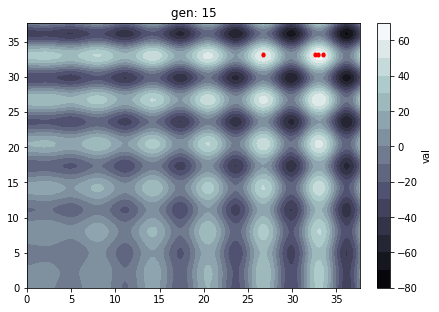

In [57]:
f = opt.datasets.history.generation == gen
df = opt.datasets.history[f]


ax.lines = []
ax.plot(df.x, df.y, 'r.')
ax.set_title(label=f'gen: {gen}')
ax.figure.savefig(f'../../img/local_max_mutation_evol{gen}', bbox_inches='tight')
gen += 1
ax.figure

### Now the Creatures gravitate towards the best solutions

## Isolating the best spaces

In [27]:
def new_process(x, y):
    if 10 < x < 30:
        x = 0
    if 10 < y < 30:
        y = 0
    return process(x, y)

def new_process_arr(x, y):
    f = ((x > 10) & (x < 30)) | ((y > 10) & (y < 30))
    x[f] = 36.2
    y[f] = 36.2
    return process(x, y)

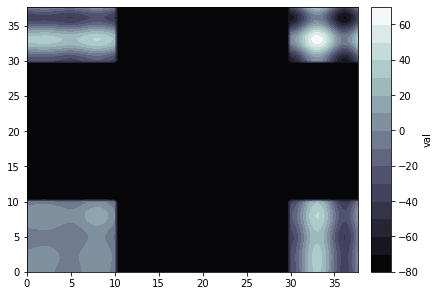

In [28]:
x = np.linspace(0, maxrange*np.pi, 100)
y = np.linspace(0, maxrange*np.pi, 100)
Xi, Yi = np.meshgrid(x, y)
Z = new_process_arr(Xi, Yi)['val']

fig, ax = plt.subplots(constrained_layout=True)
CS = ax.contourf(x, y, Z, 15, cmap=plt.cm.bone)
cbar = fig.colorbar(CS)
_ = cbar.ax.set_ylabel('val')

In [29]:
opt.set_process(new_process)

In [30]:
optpop_isolated = opt.run.single_objective(output='val', objective='max', p_mutation=0.05)

100%|██████████| 20/20 [00:00<00:00, 28.80it/s]


In [31]:
gen = 0

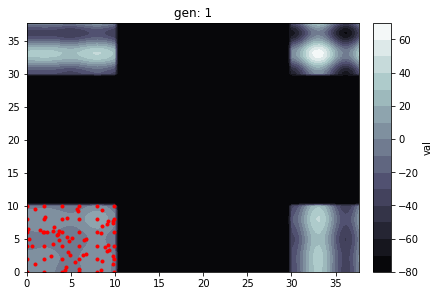

In [32]:
df = optpop_isolated.datasets.get_generation_from_history(gen)
gen += 1

ax.lines = []
ax.plot(df.x, df.y, 'r.')
ax.set_title(label=f'gen: {gen}')
ax.figure

### Creatures still gravitate towards the best solutions, but way slower

<AxesSubplot:xlabel='generation', ylabel='val'>

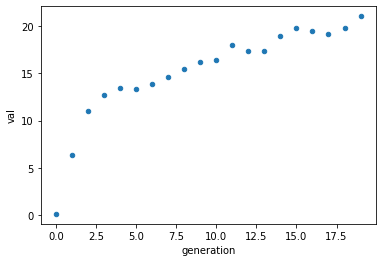

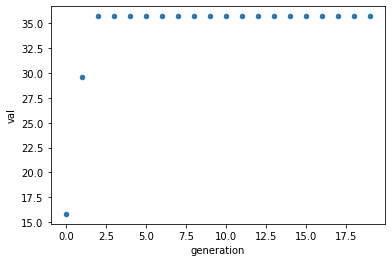

In [33]:
optpop_isolated.plot.history('val', 'mean')
optpop_isolated.plot.history('val', 'max')

## Let's try more generations

In [34]:
optpop_isolated = opt.run.single_objective(output='val', objective='max', max_generations=200, p_mutation=0.05)

100%|██████████| 200/200 [00:07<00:00, 28.47it/s]


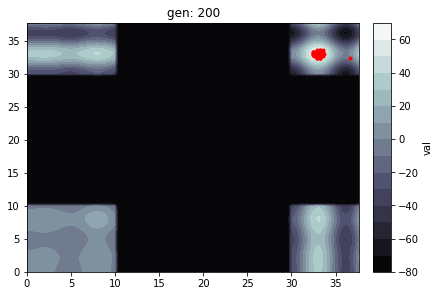

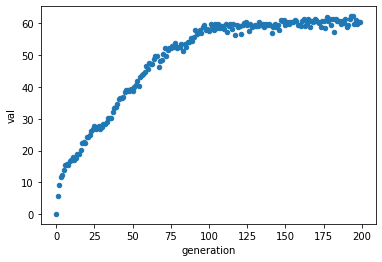

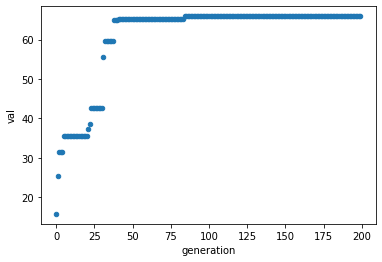

In [35]:
gen = 200

df = optpop_isolated.datasets.get_generation_from_history(gen-1)

ax.lines = []
ax.plot(df.x, df.y, 'r.')
ax.set_title(label=f'gen: {gen}')
optpop_isolated.plot.history('val', 'mean')
optpop_isolated.plot.history('val', 'max')
ax.figure

## Let's just try a bigger mutation chance

In [36]:
optpop_isolated = opt.run.single_objective(output='val', objective='max', max_generations=20, p_mutation=0.2)

100%|██████████| 20/20 [00:00<00:00, 26.32it/s]


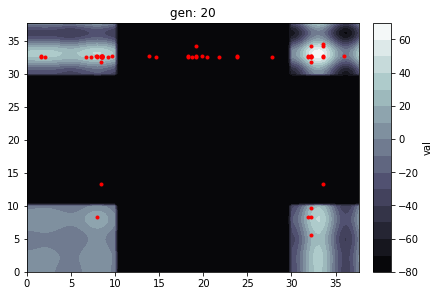

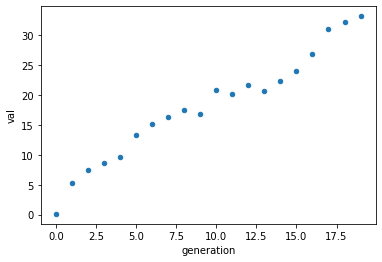

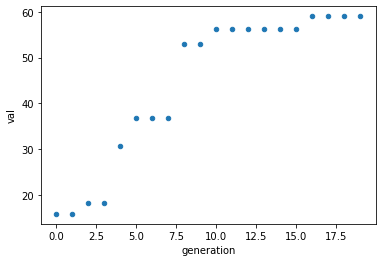

In [37]:
gen = 20

df = optpop_isolated.datasets.get_generation_from_history(gen-1)

ax.lines = []
ax.plot(df.x, df.y, 'r.')
ax.set_title(label=f'gen: {gen}')
optpop_isolated.plot.history('val', 'mean')
optpop_isolated.plot.history('val', 'max')
ax.figure